
<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">EM MICRONS Functional Data Acess</h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>The MICRONS project collected a large scale functional imaging experiment from the mouse before it went through processing for electron microscopy. This notebook will teach you how to access that data and link it to the structural measurements in the electron microscopy portion of the dataset. 

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Background</h2>

<p>
The functional data is stored in a framework called DataJoint which is backed by MySql. <a href="https://datajoint.org/">DataJoint</a> is a free, open-source framework for programming scientific databases and computational data pipelines that was developed by the Tolias Lab, and now as a for profit company. It should be pre-installed in your environment, and the json file 'dj_local_conf.json' in this folder contains the configuration about connecting to the server for you for the course. 
    
We will utilize a module called **phase3.nda**, which refers to the Microns phase 3 neural data api) to connect to the DataJoint server. The **phase3.nda** module has a module a series of tables which provide information about the functional imaging experiment, including neural activity (masks and fluorescence traces), the stimulus, the animal's behavior (running and pupil).  Ultimately the functional activity of individual regions of interest is stored in the "ScanUnit" table, which can then be linked to neurons in the electron microscopy dataset via the "functional_coreg" CAVE table, which contains primary keys of that table.
    
Outside of the course you must download this server and run it somewhere to access the data. Instructions for this can be found <a href="https://github.com/cajal/microns-nda-access">here</a>. Additional documentation about the functional data and links to technical information about the dataset are <a href="https://github.com/cajal/microns_phase3_nda">here</a>. This notebook is based on the original example notebooks provided in that repository, created by members of Andreas Tolias and Jake Reimer's groups at Baylor who created and prepared the dataset for release
</p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Local setup instructions</h2>

**to access these tables with datajoint you have to import phase3.nda, which is the primary functional data access module.**
We will also import **phase3.func** which has some helper functions for you to use, which simply use **phase3.nda** under the hood.

<h2 align="center">NDA Table Descriptions</h2>
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h3>Imaging Data Structure</h3>
    
**nda.Scan:** Scans are collections of frames that were acquired simultaneously.  They are defined by a combination of session and scan index. Information on completed scans. Cajal Pipeline: <a href="https://github.com/cajal/pipeline/blob/6a8342bf3edb07f5653c61024742258295cd8014/python/pipeline/meso.py#L29">meso.ScanInfo</a>.
    
**nda.ScanInclude:** Scans determined suitable for analysis. Some scans did not complete successfully or had incomplete data, and so are not reccomended.    
    
**nda.Field:** Individual fields of scans. Fields are single image planes. Each scan contains up to 8 fields. See <a href="https://ngl.microns-explorer.org/#!gs://microns-static-links/mm3/all_fields_coreg.json">here</a> for a visualization of the scans to understand how the fields are distributed Cajal Pipeline: <a href="https://github.com/cajal/pipeline/blob/6a8342bf3edb07f5653c61024742258295cd8014/python/pipeline/meso.py#L54">meso.ScanInfo.Field</a>. On each frame of the scan, the microscope scanned one field, then hopped to the next field, and so on ina  loop. So the individual 8 frames are spread out across the inter-scan frame time. All 8 frames were imaged within the 6.3Hz acquisition rate.
    
<h3>Functional Extraction</h3>  
    
**nda.Segmentation:** CNMF segmentation of a field using CaImAn package (https://github.com/simonsfoundation/CaImAn). It records the masks of all segmented cells. Mask_id's are unique per field. 
<br>Cajal Pipeline: <a href="https://github.com/cajal/pipeline/blob/921a920478c73687dd78b863fcd05e12bbf1e197/python/pipeline/meso.py#L765">meso.Segmentation.Mask</a>
    
**nda.Fluorescence:** Records the raw fluorescence traces for each segmented mask. 
<br>Cajal Pipeline: <a href="https://github.com/cajal/pipeline/blob/921a920478c73687dd78b863fcd05e12bbf1e197/python/pipeline/meso.py#L1159">meso.Fluorescence.Trace</a>

**nda.ScanUnit:** Unit_id assignment that is unique across the entire scan. Includes info about each unit. 
<br>Cajal Pipeline: <a href="https://github.com/cajal/pipeline/blob/921a920478c73687dd78b863fcd05e12bbf1e197/python/pipeline/meso.py#L1341">meso.ScanSet.Unit / meso.ScanSet.UnitInfo</a>
    
**nda.MaskClassification:** Classification of segmented masks into soma or artifact. Uses CaImAn package (https://github.com/simonsfoundation/CaImAn). 
<br>Cajal Pipeline: <a href = "https://github.com/cajal/pipeline/blob/6f44fdbd186905d95a9a86d6d60ad147df24f9e2/python/pipeline/meso.py#L1478">meso.MaskClassification.Type</a>
    
<h3>Functional Analysis</h3> 
    
**nda.Activity:** Deconvolved spike trace from the fluorescence trace. <br>Cajal Pipeline: <a href= "https://github.com/cajal/pipeline/blob/921a920478c73687dd78b863fcd05e12bbf1e197/python/pipeline/meso.py#L1501">meso.Activity.Trace</a>

**nda.Oracle:** Measures how reliably each ScanUnit responds to visual stimulus Leave-one-out correlation for repeated videos in stimulus.

**nda.AreaMembership:** Visual area labels for all units.
    
<h3>Timing and stimulus</h3>

**nda.FrameTimes:** Timestamps of scan frames in seconds relative to the start of the scan for the first pixel of the first imaging field.  You can use this to get a precise timing of each unit in a consistent timebase.

**nda.Stimulus:** For each scan, contains the movie aligned to activity traces in `nda.Activity`. Note, this movie is now temporly downsampled to match the acquisition rate of the activity, but **does NOT reflect the temporal properties of the stimulus** that was actually shown to the animal. You have to download the actual stimulus movie at 30Hz if you want precise temporarily correct information about the pixels shown to the mouse during the scan. (see below)

**nda.Trial:** Contains information for each trial of the movie in `nda.Stimulus`. There are three types of trials, `Clip`, `Monet2`, and `Trippy`. Each unique trial has its own `condition_hash`. To get detailed information for each trial stimulus, join each `condition_hash` according to its corresponding type in one of: `nda.Clip`, `nda.Monet2`, or `nda.Trippy`.

**nda.Clip:** Detailed information for movie clips.

**nda.Monet2:** Detailed information for the Monet2 stimulus.

**nda.Trippy:** Detailed information for the Trippy stimulus.


<h3>Behavior</h3>

**nda.RawManualPupil:** Pupil traces for each scan from the left eye collected at ~20 Hz and semi-automatically segmented. 

**nda.ManualPupil:** Manual pupil traces low-pass filtered with a hamming window to the scan frame rate and linearly interpolated to scan frame times.

**nda.RawTreadmill:** Cylindrical treadmill rostral-caudal position extracted with a rotary optical encoder at ~100Hz and converted into velocity.

**nda.Treadmill:** Treadmill velocities low-pass filtered with a hamming window to the scan frame rate then linearly interpolated to scan frame times.
    
<h3> Co-registration </h3>
For most of your purposes, you can utilize the caveclient table 'functional_coreg' to find the ScanUnit information about neurons that have been coregistered, but if you are interested in diving into the details of the transformation, these tables are useful. 
    
**nda.MeanIntensity:** Mean intensity of imaging field over time. <br>Cajal Pipeline: <a href="https://github.com/cajal/pipeline/blob/fa202ee43437a67d55719e8ae9769ee9937581d0/python/pipeline/meso.py#L173">meso.Quality.MeanIntensity</a>
    
**nda.SummaryImages:** Reference images of the scan field. <br>Cajal Pipeline: <a href="https://github.com/cajal/pipeline/blob/921a920478c73687dd78b863fcd05e12bbf1e197/python/pipeline/meso.py#L571">meso.SummaryImages</a>   
    
**nda.Stack:** High-res anatomical stack information. <br>Cajal Pipeline: <a href="https://github.com/cajal/pipeline/blob/6a8342bf3edb07f5653c61024742258295cd8014/python/pipeline/stack.py#L733">stack.CorrectedStack</a> 
    
**nda.Registration:** Parameters of the affine matrix learned for field registration into the stack. <br>Cajal Pipeline: <a href="https://github.com/cajal/pipeline/blob/6a8342bf3edb07f5653c61024742258295cd8014/python/pipeline/stack.py#L1333">stack.Registration.Affine</a>    
    
**nda.Coregistration:** Coregistration transform solutions from the Allen Institute. <a href="https://github.com/AllenInstitute/em_coregistration/phase3">em_coregistration</a>   
    
**nda.StackUnit:** Unit coordinates in stack reference frame after field registration. `np_x, np_y, np_z` should be used for transformation to EM space using Coregistration. <a href="https://github.com/cajal/pipeline/blob/921a920478c73687dd78b863fcd05e12bbf1e197/python/pipeline/meso.py#L1672">meso.StackCoordinates.UnitInfo</a>  
    


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2 align="center">For more documentation see: <a href="https://cajal.github.io/atlab-docs.github.io/pipeline.html">Cajal Pipeline Documentation</a></h2>





In [1]:
%%capture
from phase3 import nda, func #phase3 nda 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h2>Table Diagram</h2>
    
The data from these tables are related in ways that allow you to perform certain manipulations, such as joining and merging. To help you see the relationships between these tables, the below graph represents tables as nodes and dependencies as directed edges between them.  The lines indicate which tables can be joined together, as they share foriegn keys. Datajoint's design is to make merges simple by enforcing strict structure on how column names should match across tables. </div>

<img src="../resources/nda_erd.png"> 

In [ ]:
# to get a unique scan: need to specify: 1. session + 2. scan_inx (no meaning)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h2>Basic DataJoint tutorial and data introduction</h2>
    
This tutorial will focus on basic DataJoint usage and introduce the functional data in the schema. 

For detailed information on the contents of the schema, please find our technical documentation <a href="https://www.microns-explorer.org/cortical-mm3#f-data">here</a>. 


<h3> Scan Table </h3>

Information from the completed scans are located in `nda.Scan`.

A scan represents one time the mouse was put under the microscope and imaging data was collected.

Each **session** happened on a single day, and **scan_idx** happened within those sessions.
***Note scan_idx is not unique**, so its the combination of **session** and **scan_idx** which is unique.

Access the table by calling:
 </div>   

In [2]:
nda.Scan() #data joint object (not a dataframe)

session Session ID,scan_idx Scan ID,nframes number of frames per scan,nfields number of fields per scan,fps frames per second (Hz)
4,7,40000,8,6.3009
4,9,35112,8,6.3009
4,10,40000,8,6.3009
5,3,40000,8,6.3009
5,6,40000,8,6.3009
5,7,40000,8,6.3009
6,2,40000,8,6.3009
6,4,40000,8,6.3009
6,6,40000,8,6.3009
6,7,40000,8,6.3009


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Pandas conversion </h3>
    
You can convert these datajoint objects to dataframes by just declaring them as dataframes
  </div>

In [3]:
pd.DataFrame(nda.Scan()) #convert data joint into data frame 

,session,scan_idx,nframes,nfields,fps
0,4,7,40000,8,6.30090
1,4,9,35112,8,6.30090
2,4,10,40000,8,6.30090
3,5,3,40000,8,6.30090
4,5,6,40000,8,6.30090
5,5,7,40000,8,6.30090
6,6,2,40000,8,6.30090
7,6,4,40000,8,6.30090
8,6,6,40000,8,6.30090
9,6,7,40000,8,6.30090


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Primary Keys </h3>
    
<a href="https://docs.datajoint.io/python/definition/07-Primary-Key.html">Primary keys </a> are a subset of its attributes that uniquely identify each entity in the table.
    
</div>

In [4]:
[*nda.Scan.heading.primary_key] 
# primary keys (similar to index in pandas, but here you can have more than one 'indexes')

['session', 'scan_idx']

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Restrict to a single scan </h3>
    
Dictionaries serve as keys for restricting table entries. Scans are indexed by `session` and `scan_idx`. The `session` attribute is the ID indicating the imaging period for the mouse. `scan_idx` is the index of the scan within the imaging session.

<h3> the '&' syntax </h3>
    
Using '&' with datajoint is like doing a filter on the table. 

The object on the right hand side of the filter must contain primary keys of the table on the left.

This can work with dictionaries you construct, assuming you name the columns to match the table you are filtering on.

For example, if we want to pull out a single scan, we can construct a dictionary with that Scan's primary key. 
    
</div>

In [6]:
scan_key = {'session': 4, 'scan_idx': 7} 
scan_key

{'session': 4, 'scan_idx': 7}

In [7]:
# basic filtering synatax: use the scan_key id'ed above and pull out the data frames 
pd.DataFrame(nda.Scan & scan_key) 

,session,scan_idx,nframes,nfields,fps
0,4,7,40000,8,6.3009


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 1.1:</b>  Pick out a different scan session
</div>

In [8]:
scan_key = {'session': 4, 'scan_idx': 9} 
pd.DataFrame(nda.Scan & scan_key) 

,session,scan_idx,nframes,nfields,fps
0,4,9,35112,8,6.3009


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Restrict to a multiple scans </h3>
    
Use a list of dictionaries to restrict to multiple entries.
</div>

In [9]:
scan_keys = [{'session': 4, 'scan_idx': 7}, {'session': 5, 'scan_idx': 3}]

In [10]:
# you can create a list of dictionaries (scan_keys above, and pull multiple scans)
scan_res=pd.DataFrame(nda.Scan & scan_keys)
scan_res

,session,scan_idx,nframes,nfields,fps
0,4,7,40000,8,6.3009
1,5,3,40000,8,6.3009


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Included Scans </h3>
    
Scans designated for inclusion into analysis are found in `nda.ScanInclude`. Restrict against `nda.Scan` to apply.
</div>


In [12]:
# here '&' filters out Scans to only include those 
# that completed successfully
pd.DataFrame(nda.Scan & nda.ScanInclude) #use '&' with 2 tables as well
# 5 scans are excluded from analysis

,session,scan_idx,nframes,nfields,fps
0,4,7,40000,8,6.30090
1,5,6,40000,8,6.30090
2,5,7,40000,8,6.30090
3,6,2,40000,8,6.30090
4,6,4,40000,8,6.30090
5,6,6,40000,8,6.30090
6,6,7,40000,8,6.30090
7,7,3,40000,8,6.30090
8,7,4,40000,8,6.30090
9,7,5,40000,8,6.30090


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Field information </h3>
    
Each scan (identified by `session` and `scan_idx`) can have multiple imaging fields. These fields are indexed by the `field` attribute. `nda.Field` containes information for all imaging fields available for a scan.
</div>


In [14]:
# note that even though scan_key only has one entry
# there are multiple fields that match, so the filter
# returns all of them
nda.Field & scan_key

# fields are different imaging planes

session Session ID,scan_idx Scan ID,field Field Number,px_width field pixels per line,px_height lines per field,um_width field width (microns),um_height field height (microns),field_x field x motor coordinates (microns),field_y field y motor coordinates (microns),field_z field z motor coordinates (microns)
4,9,1,248,440,620.0,1100.0,-485.0,-235.0,90.0
4,9,2,248,440,620.0,1100.0,95.0,-235.0,90.0
4,9,3,248,440,620.0,1100.0,-485.0,-235.0,230.0
4,9,4,248,440,620.0,1100.0,95.0,-235.0,230.0
4,9,5,248,440,620.0,1100.0,-485.0,-235.0,370.0
4,9,6,248,440,620.0,1100.0,95.0,-235.0,370.0
4,9,7,248,440,620.0,1100.0,-485.0,-235.0,510.0
4,9,8,248,440,620.0,1100.0,95.0,-235.0,510.0


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Use a `field_key` to restrict to a single entry.
</div>


In [15]:
field_key = {'session': 4, 'scan_idx': 7, 'field': 4}

In [16]:
nda.Field & field_key

session Session ID,scan_idx Scan ID,field Field Number,px_width field pixels per line,px_height lines per field,um_width field width (microns),um_height field height (microns),field_x field x motor coordinates (microns),field_y field y motor coordinates (microns),field_z field z motor coordinates (microns)
4,7,4,248,440,620.0,1100.0,95.0,-235.0,220.0


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 1.2:</b>  Find the fields in the scan you picked that have z coordinates less than 200 um? Hint, you don't have to specify all parts of the primary key to still have filter work
</div>

In [33]:
#field_key = {'session': 4, 'scan_idx': 8,  }
my_scan_key = {'session': 6, 'scan_idx': 7} 
my_scan = pd.DataFrame(nda.Scan & my_scan_key)
my_scan

#use query to find all the Field data that has field_z is less than 200 
pd.DataFrame(nda.Field  & my_scan_key).query('field_z<200')

,session,scan_idx,field,px_width,px_height,um_width,um_height,field_x,field_y,field_z
0,6,7,1,248,440,620.0,1100.0,-520.0,-280.0,100.0
1,6,7,2,248,440,620.0,1100.0,60.0,-280.0,100.0


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
To visualize how these scans and fields are distributed
lets make a plot where each field is a line at a particular depth
covering the extent of the field, and fields from the same scan get the same color. Look! we can filter with other tables too.
</div>

In [27]:
# first lets grab all the fields from included scans
fields=pd.DataFrame(nda.Field & nda.ScanInclude)
fields.groupby(['session', 'scan_idx']).field.count()

session  scan_idx
4        7           8
5        6           8
         7           8
6        2           8
         4           8
         6           8
         7           8
7        3           8
         4           8
         5           8
8        5           8
9        3           6
         4           6
         6           4
Name: field, dtype: int64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 1.3:</b>  Make a list called <code>scans</code> with all the scan keys. How many unique scans are in this list of included fields?
</div>

In [34]:
scans = fields.groupby(['session', 'scan_idx']).groups.keys()
len(scans)

14

In [35]:
# we need 14 colors, matplotlib standard palette has 10, so we will add 4 more
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.keys()) + ['mediumblue', 'greenyellow',
                                       'peachpuff', 'darkcyan' ]
len(colors)

14

In [36]:
# now lets construct a dictionary where the key is the
# combination of session, scan_idx and the color string is value
scan_colors_dict = {f:c for f,c in zip(scans, colors)} #zip the two dictionaries 
scan_colors_dict

{(4, 7): 'tab:blue',
 (5, 6): 'tab:orange',
 (5, 7): 'tab:green',
 (6, 2): 'tab:red',
 (6, 4): 'tab:purple',
 (6, 6): 'tab:brown',
 (6, 7): 'tab:pink',
 (7, 3): 'tab:gray',
 (7, 4): 'tab:olive',
 (7, 5): 'tab:cyan',
 (8, 5): 'mediumblue',
 (9, 3): 'greenyellow',
 (9, 4): 'peachpuff',
 (9, 6): 'darkcyan'}

Text(0, 0.5, 'depth ($\\mu m$)')

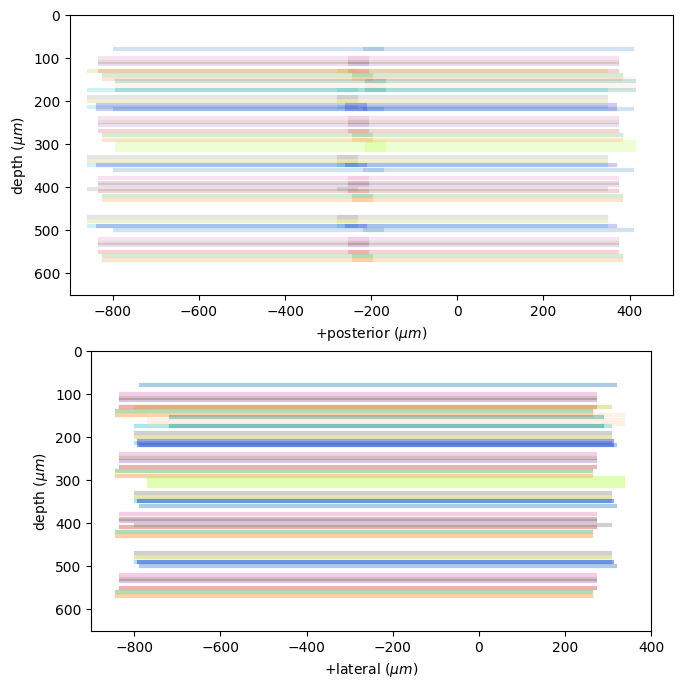

In [37]:

# one subplot for x,z and one for y,z
f, ax = plt.subplots(2,1,figsize=(8,8))
for k, row in fields.iterrows():
    # now we can plot these as individual lines, and use our color dictionary
    # to color them
    
    # line for the x,z view
    linex = plt.Line2D([row.field_x - row.um_width/2, row.field_x+row.um_width/2], 
                       [row.field_z, row.field_z], linewidth=3, alpha=.2,
                      color=scan_colors_dict[(row.session, row.scan_idx)])
    # line for the y,z view
    liney = plt.Line2D([row.field_y - row.um_height/2, row.field_y+row.um_height/2], 
                       [row.field_z, row.field_z], linewidth=3, alpha=.2,
                      color=scan_colors_dict[(row.session, row.scan_idx)])
    ax[0].add_line(linex)
    ax[1].add_line(liney)
# #  uncomment to overlay text of field numbers 
#     text = plt.Text(x=row.field_x, y=row.field_z, text=f'{int(row.field)}')
#     texty = plt.Text(x=row.field_y-(20*int(row.field%2)), y=row.field_z, text=f'{int(row.field)}')
#     ax[0].add_artist(text)
#     ax[1].add_artist(texty)
# when using raw lines you have to set axis
ax[0].set_xlim(-900,500)
ax[0].set_ylim(650,0)
ax[0].set_aspect('equal')
ax[0].set_xlabel('+posterior ($\mu m$)')
ax[0].set_ylabel('depth ($\mu m$)')
    
ax[1].set_xlim(-900,400)
ax[1].set_ylim(650,0)
ax[1].set_aspect('equal')
ax[1].set_xlabel('+lateral ($\mu m$)')
ax[1].set_ylabel('depth ($\mu m$)')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Fields from the same Scan are now colored the same color.
You can see how they are distributed in depth, and how the 
fields cover more medial-lateral distance than anterior-posterior.
The lateral view is darker because each field perfectly overlaps and the alpha values add.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Frame Times </h3>
    
The timestamp of each scan frame (in seconds) relative to the start of the scan is located in `nda.FrameTimes`. Note this is the time that field=1 started. If you care to localize units with precision greater than 6.3Hz you will need to account for the fact that each from will be distributed across the 1/6.3=158ms interval. 
</div>
  

In [38]:
nda.FrameTimes() & scan_key

session Session ID,scan_idx Scan ID,frame_times stimulus frame times for the first pixel of field 1 of each scan (len = nframes),ndepths number of imaging depths recorded for each scan
4,9,=BLOB=,4


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
The `frame_times` attribute contains the timestamp for each frame synced to the first pixel of the first field (`field 1`) in `nda.Field`. 
<br>  
    
**What does =BLOB= mean**<br/>
This is a binary element in the database. Usually this is a numpy array.
Note, when you convert a whole query to a dataframe it will pull that binary
data out of the database. This can take a long time if the =BLOB= is big. 
If you don't convert, it will just list it as =BLOB=. 
</div>

In [39]:
frame_times = pd.DataFrame(nda.FrameTimes & scan_key)['frame_times'].values[0]
len(frame_times)

35112

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 1.4:</b>  Plot when these frametimes occur as a raster
</div>

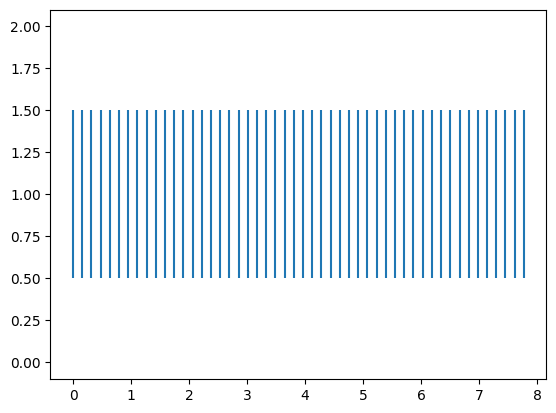

In [43]:
plt.eventplot(frame_times[0:50])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
You can confirm that the timestamps are at the scan frame frequency by recovering the scan fps. 
</div>


In [49]:
1/np.mean(np.diff(frame_times)) # find the avaerge frame rate (Hz)
# use np.diff to find the difference between two consecutive numbers in a list

6.298179728987371

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 1.5:</b>  Calculate the average and std between these frametimes
</div>

In [53]:
np.std(np.diff(frame_times)) #standard deviation 

0.00037914531980890543

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Stimulus </h3>
    
A temporarily downsampled and synced version of the movie shown to the mouse for each scan is housed in `nda.Stimulus`. The movie is synced to the timestamps in `nda.FrameTimes`.
</div>


In [51]:
nda.Stimulus() #do not want to convert all the movies into data frames
# so  we don't have extract all the movies

session Session ID,scan_idx Scan ID,movie stimulus images synchronized with field 1 frame times (H x W x T matrix)
4,7,=BLOB=
4,9,=BLOB=
4,10,=BLOB=
5,3,=BLOB=
5,6,=BLOB=
5,7,=BLOB=
6,2,=BLOB=
6,4,=BLOB=
6,6,=BLOB=
6,7,=BLOB=


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Here is an example where you wouldn't want to convert this whole query result to a dataframe, as all those BLOB elements are 90x160x40000 matrices. 

So lets filter down first, and use a datajoin specific method **fetch1** to pull out one column from the first row. 

There is also **fetch** which will pull out all the rows from one or more columns. 
</div>



In [60]:
scan_key = {'session': 4, 'scan_idx': 7}
movie = (nda.Stimulus & scan_key).fetch1('movie') # stimulus images synchronized with nda.FrameTimes
movie.shape #(height x width x frames)

(90, 160, 40000)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 1.5:</b>  Look at one of the frames of this stimulus
</div>

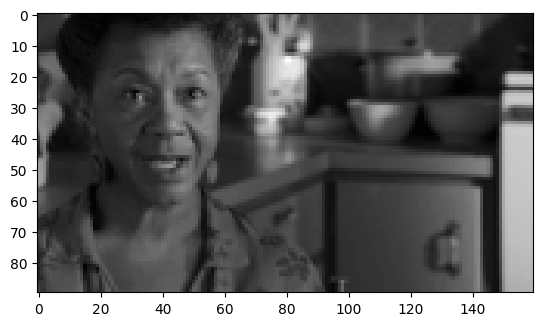

In [67]:
plt.imshow(movie[:,:,25000],cmap=plt.cm.gray)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Trials </h3>
    
A trial represents a short segment of the stimulus. Trial information is logged in `nda.Trial` and indexed by `trial_idx`. 

There are three types of trials: `Clip`, `Monet2`, and `Trippy`. 

`Clip` types show segments that contain high-entropy scenes such as Hollywood clips, sports clips and rendered movies. 

`Monet2` and `Trippy` types show parametric segments. 

Each stimulus segment has a unique identifier in its `condition_hash` and are indexed in the tables `nda.Clip`, `nda.Monet2`, and `nda.Trippy`. 

`start_idx` and `stop_idx` are the indices of the movie in `nda.Stimulus` during which the trial was ongoing. 

`start_frame_time` and `end_frame_time` are the timestamps of the `start_idx` and `end_idx` in seconds relative to the start of the scan. 

`frame_times` are the timestamps of every frame shown in the movie segment at the original presentation frequency (not synced to the scan). 

*Note that in `nda.Trial`, `frame_times` differs the attribute `frame_times` in `nda.FrameTimes`. Nomenclature will be updated and clarified in a future version.*
</div>


In [68]:
trial_df = pd.DataFrame(nda.Trial & scan_key)
trial_df

,session,scan_idx,trial_idx,type,start_idx,end_idx,start_frame_time,end_frame_time,frame_times,condition_hash
0,4,7,0,stimulus.Clip,55,118,8.697065,18.663578,"[8.697064569452493, 8.730412414530008, 8.76373...",JEL5/i5FccX4ykUOKaDW
1,4,7,1,stimulus.Clip,119,182,18.763564,28.730076,"[18.763563802698343, 18.796907356241434, 18.83...",AAQ1HNKGrg1cIXlMw7nz
2,4,7,2,stimulus.Clip,182,245,28.830070,38.796571,"[28.830070426920145, 28.86340229795286, 28.896...",ksTS42zV+O0YJqa0+s4Y
3,4,7,3,stimulus.Clip,246,308,38.896565,48.863070,"[38.89656536863157, 38.92988865659544, 38.9632...",m5JLObtSRnbRKw1ukcSE
4,4,7,4,stimulus.Clip,309,372,48.963060,58.929562,"[48.963060310342996, 48.996388843515604, 49.02...",L8Z/mji+v1WipuJe4GaL
...,...,...,...,...,...,...,...,...,...,...
459,4,7,459,stimulus.Clip,31548,31611,5008.780256,5018.746762,"[5008.780256441096, 5008.813589504221, 5008.84...",owkBHih6INnj1E45lT8d
460,4,7,460,stimulus.Trippy,31612,31706,5018.846758,5033.829829,"[5018.846758296946, 5018.863422325114, 5018.88...",5/1FqWTahoTvRpmjfXdl
461,4,7,461,stimulus.Trippy,31707,31801,5033.913160,5048.896257,"[5033.91316049383, 5033.929828336695, 5033.946...",+4gByvU9LfvSD0JHP6Ae
462,4,7,462,stimulus.Trippy,31801,31896,5048.979574,5063.962665,"[5048.979574373225, 5048.996248414973, 5049.01...",S3YyVltepwIk1BYeNSvC


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 1.7:</b>  How many trial types are there? And how many total trials?
</div>

In [70]:
trial_df.type.value_counts()

stimulus.Clip      384
stimulus.Monet2     40
stimulus.Trippy     40
Name: type, dtype: int64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 1.8:</b>  How many times was each unique stimulus shown? (save this as a dataframe) 
</div>

In [82]:
trial_df.columns

Index(['session', 'scan_idx', 'trial_idx', 'type', 'start_idx', 'end_idx',
       'start_frame_time', 'end_frame_time', 'frame_times', 'condition_hash'],
      dtype='object')

In [77]:
# condition_hash is one of the variables in trial that is an index for that clip
nshown = trial_df.groupby('condition_hash').type.count()
nshown=pd.DataFrame(nshown) # convert to data frame
nshown

,type
condition_hash,
+4gByvU9LfvSD0JHP6Ae,2
+DqYQkvkSP6i+eLp+/m1,1
+rgSVBVRE8Ij1WNhq8ZW,2
07ZlK5NBmsi4SsKD9/mI,1
0JcYLY6eaQxNgD0AqyHf,2
...,...
ypW4fTmjYiXqhojT8ftw,1
ysjy6YgGXX5+mcx52KSM,2
yv/S61fYnDSQcA9J6Nk8,2


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 1.9:</b>  What are the hashes for the stimuli that are repeated 10 times?
</div>

In [81]:
sum(nshown.type == 10)

nshown.query('type==10') # 6 clips that are shown 10 times in every scans

,type
condition_hash,
5zQTb77qI+ig8rigx1XU,10
7UETOWO5Z8aWuHDBJ2GG,10
GjCMo2GkJp6y5vricadg,10
KXdTNAGMo1gCWz2Ge8zr,10
Oup5uAZxF2G7zEJkT+ui,10
ecUQJtcERZJGdqza1k7h,10


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Detailed information about the stimulus during each trial can be obtained by restricting into the appropriate type-specific table. The example trial_key below restricts to a `Monet2` type trial.
</div>
 

In [83]:
trial_key = {'session': 4, 'scan_idx': 7, 'trial_idx': 8} # pick a particular trial

In [84]:
trial_info = nda.Trial & trial_key
trial_info

session Session ID,scan_idx Scan ID,trial_idx index of trial within stimulus,type type of stimulus trial,start_idx index of field 1 scan frame at start of trial,end_idx index of field 1 scan frame at end of trial,start_frame_time start time of stimulus frame relative to scan start (seconds),end_frame_time end time of stimulus frame relative to scan start (seconds),frame_times full vector of stimulus frame times relative to scan start (seconds),condition_hash 120-bit hash (The first 20 chars of MD5 in base64)
4,7,8,stimulus.Monet2,626,720,99.24554627225706,114.22863238141844,=BLOB=,GHn0W57E+2PS+Qr5yD2r


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<a href= "https://docs.datajoint.io/python/queries/07-Join.html">Join</a> `trial_info` with `nda.Monet2` using the `*` operator to get all available information about the stimulus during that trial. 

<h3> The * operator </h3>

The * operator is like pandas merge with how='inner' so it finds all the rows that match on both sides.  It doesn't need to specify left_on, right_on or on, because the matching keys are already programmed into the relational database.

<h3> Monet2 </h3>

For this join in particular, `Monet2` is a directional stimuli, and the vector of directions during the trial is stored in the `directions` attribute. See technical methods for a more detailed description of the contents of this and other stimulus type tables. 
</div>


In [86]:
trial_info * nda.Monet2


# monet stim: 16 blocks, and each block has a direction, 
# the directions are randomly applied, and have a direction specified 

session Session ID,scan_idx Scan ID,trial_idx index of trial within stimulus,condition_hash 120-bit hash (The first 20 chars of MD5 in base64),type type of stimulus trial,start_idx index of field 1 scan frame at start of trial,end_idx index of field 1 scan frame at end of trial,start_frame_time start time of stimulus frame relative to scan start (seconds),end_frame_time end time of stimulus frame relative to scan start (seconds),frame_times full vector of stimulus frame times relative to scan start (seconds),fps display refresh rate,duration (s) trial duration,rng_seed random number generator seed,"blue_green_saturation 0 = grayscale, 1=blue/green",pattern_width width of generated pattern,pattern_aspect the aspect ratio of the pattern,temp_kernel,temp_bandwidth (Hz) temporal bandwidth of the stimulus,ori_coherence 1=unoriented noise. pi/ori_coherence = bandwidth of orientations.,ori_fraction fraction of time coherent orientation is on,ori_mix mixin-coefficient of orientation biased noise,n_dirs number of directions,"speed unit/s motion component, where unit is display width",directions computed directions of motion in degrees,onsets computed direction onset (seconds),movie rendered uint8 movie (H X W X 1 X T)
4,7,8,GHn0W57E+2PS+Qr5yD2r,stimulus.Monet2,626,720,99.24554627225706,114.22863238141844,=BLOB=,60.000,15.000,8.0,0.000,72,1.7,hamming,4.00,2.50,1.0,1.0,16,0.2,=BLOB=,=BLOB=,=BLOB=


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
We can get the actual stimulus movie shown, and the timing of the individual frames from these more detailed tables.
    
Note, the timing of these frames is now 60Hz
</div>


In [87]:
monet_info=trial_info * nda.Monet2
mov_frame_times = monet_info.fetch1('frame_times')
mov = monet_info.fetch1('movie')

In [88]:
1/np.diff(mov_frame_times).mean() # to the the mean freq of presentation (60Hz)

60.000990013019305

In [89]:
mov.shape

(126, 216, 1, 900)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Lets plot 8 frames from the movie. Feel free to play around with the offset and skips to see different parts 
</div>


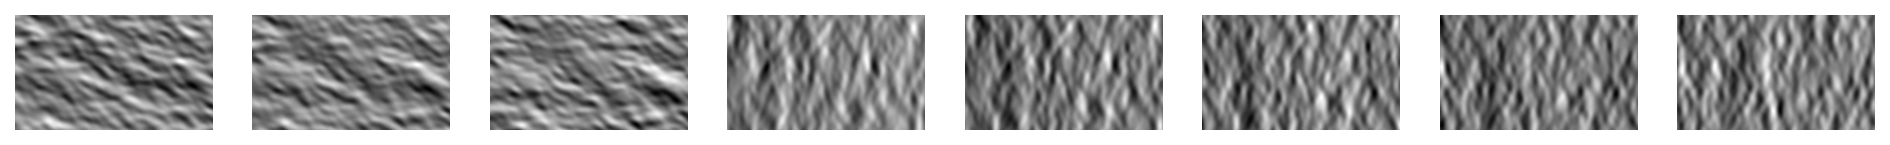

In [90]:
offset = 45
skips = 5
fig, axs = plt.subplots(1, 8, dpi=150, figsize=(16,4)) 
for n in range(8):
    axs[n].imshow(mov[:,:,0,n*skips+offset], cmap='gray')
[ax.axis('off') for ax in axs.ravel()];


In [92]:
directions, onsets = monet_info.fetch1('directions', 'onsets')
directions_df = pd.DataFrame({'onset': onsets[0,:], 'direction':directions[0,:]})
duration = float(monet_info.fetch1('duration'))
offsets = np.concatenate([directions_df['onset'][1:],[duration]])
directions_df['offset']=offsets
directions_df

# example to put in student repo

,onset,direction,offset
0,0.0000,202.5,0.9375
1,0.9375,90.0,1.8750
2,1.8750,180.0,2.8125
3,2.8125,45.0,3.7500
4,3.7500,67.5,4.6875
5,4.6875,315.0,5.6250
6,5.6250,22.5,6.5625
7,6.5625,225.0,7.5000
8,7.5000,292.5,8.4375
9,8.4375,270.0,9.3750


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 1.11:</b>  At what time in the scan did this Trial start showing a 315 degree oriented stimulus? 
</div>

In [96]:
directions_df.query('direction==315')

,onset,direction,offset
5,4.6875,315.0,5.625


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
How might we find frames based upon these event times.  Using np.searchsorted with the frame_times can help here. 
</div>

In [97]:
# how to correlate the stimulus presentation and frames presented (use np.searchsorted )

directions_df['onset_time']=directions_df['onset']+monet_info.fetch1('start_frame_time')
directions_df['offset_time']=directions_df['offset']+monet_info.fetch1('start_frame_time')

directions_df['onset_frame_number']=np.searchsorted(frame_times, directions_df.onset_time)+1
directions_df['offset_frame_number']=np.searchsorted(frame_times, directions_df.offset_time)

# sort the times with respect to directions
directions_df.sort_values('direction', inplace=True)


In [ ]:
directions_df

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Use `start_idx` and `end_idx` to view the part of the stimulus corresponding to the trial.
</div>


In [ ]:
#start, end = pd.DataFrame(trial_info * nda.Monet2).loc[0,['start_idx', 'end_idx']] # Fetch indices of trial
#print(f'Trial starts at index: {start} and ends at index {end}')

In [98]:
# we can slice the stimulus aligned movie according to indices of trial
onset_trial_slice = movie[:,:,directions_df.onset_frame_number] 
offset_trial_slice = movie[:,:,directions_df.offset_frame_number-1] 
onset_trial_slice.shape

(90, 160, 16)

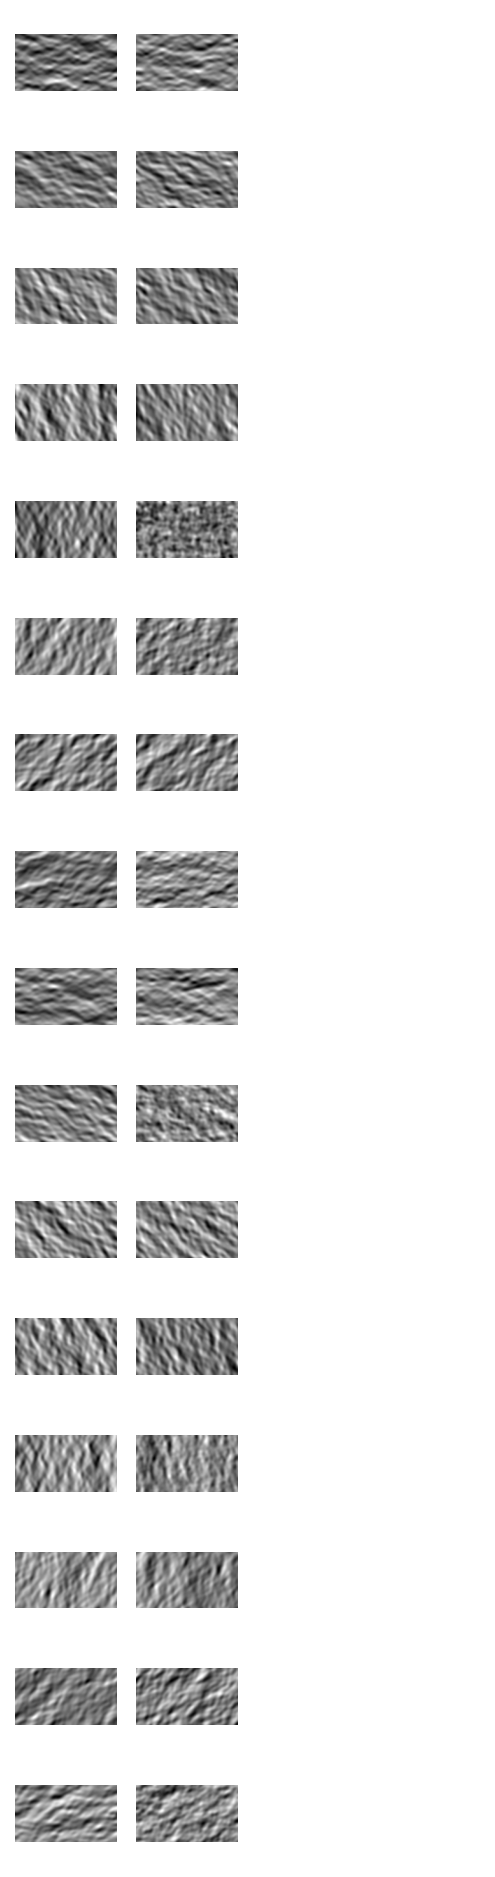

In [99]:
fig, axs = plt.subplots(16, 4, dpi=150, figsize=(4,16)) 
for n in range(onset_trial_slice.shape[2]):
    axs[n,0].imshow(onset_trial_slice[:,:,n], cmap='gray')
    axs[n,1].imshow(offset_trial_slice[:,:,n], cmap='gray')
    #axs[0].set_title(f'direction: {start}')
#axs[1].imshow(stimulus_trial_slice[:,:,-1], cmap='gray')
#axs[1].set_title(f'frame: {end}')
[ax.axis('off') for ax in axs.ravel()];

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Stimulus from AWS Bucket </h3>
    
The stimuli presented above are temporarily downsampled and aligned to the functional recording as convienient ways to represent stimulus and activity in the same index.  However, the actual stimulus shown to the animal was presented at 60Hz, with the first frame starting at time=0. The complete 60Hz stimulus shown during each scan can be downloaded from an AWS bucket.
</div>


In [ ]:
import requests
import skvideo.io

In [ ]:
base_url = 'https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/functional_data/stimulus_movies'

In [ ]:
filename = f'stimulus_17797_{scan_key["session"]}_{scan_key["scan_idx"]}_v1.avi'

In [ ]:
url = base_url + '/' + filename
url

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Uncomment the below cell to download movie. Each movie is approx 2GB movie. This will write the stimulus to the current directory as an avi. 
</div>


In [109]:
# movie_aws = requests.get(url) 

# with open(filename, 'wb') as f:
#     f.write(movie_aws.content) 
field_key = {'session': 4, 'scan_idx': 7}

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Summary Image </h3>
    
A summary image of the field can be found in `nda.SummaryImages`. 

There are two types of images available, `correlation` and `average`. Details of how these are computed can be found in the accompanying methods.
</div>


In [110]:
nda.SummaryImages & field_key

session Session ID,scan_idx Scan ID,field Field Number,correlation correlation image,average average image
4,7,1,=BLOB=,=BLOB=
4,7,2,=BLOB=,=BLOB=
4,7,3,=BLOB=,=BLOB=
4,7,4,=BLOB=,=BLOB=
4,7,5,=BLOB=,=BLOB=
4,7,6,=BLOB=,=BLOB=
4,7,7,=BLOB=,=BLOB=
4,7,8,=BLOB=,=BLOB=


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Fetch and View Image </h3>
    

</div>

In [112]:
corr, avg = (nda.SummaryImages & field_key).fetch1('correlation', 'average')

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10,6), dpi=200)
axs[0].imshow(corr)
axs[0].set_title('correlation image')
axs[1].imshow(avg)
axs[1].set_title('average image')
axs[2].imshow(corr*avg) # gives a good view of the cell bodies and darkens vessels
axs[2].set_title('correlation * average image')
[ax.axis('off') for ax in axs];
[ax.set_aspect('auto') for ax in axs];

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Masks </h3>
    
The functional ROI segmentation gives a set of 2D masks indexed by `mask_id`, which are unique per `field`. A cell that was scanned in more than one imaging field will have more than one mask. Masks are stored in `nda.Segmentation`. Classification of masks as `soma` or `artifact` is stored in `nda.MaskClassification`. See technical documentation for further details on segmentation and classification methods.
</div>


In [107]:
nda.Segmentation * nda.MaskClassification & field_key

session Session ID,scan_idx Scan ID,field Field Number,mask_id,pixels indices into the image in column major (Fortran) order,weights weights of the mask at the indices above,mask_type classification of mask as soma or artifact


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Fetch masks and plot over the summary image to view them. 

*Note: the image below is intended to show the density and location of masks, but to better visualize the shape and weights of individual masks, plot them one at a time.*
    
</div>



In [ ]:
# function that will retrieve masks in convenient format and optionally plot
masks = func.get_all_masks(field_key, mask_type='soma', plot=True) 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Single Unit Information </h3>
    
For the purposes of this schema, a `unit` is a re-indexing of all masks across all imaging fields of a scan and indexed by `unit_id`. `unit_id` is unique per scan.

Note: `unit_id` is not a consolidation step, only re-indexing. Therefore, if a cell was scanned in multiple imaging fields within the scan, it will have multiple `mask_id's`, and it will also have multiple `unit_id's`. 

Information for all units in the scan can be found in `nda.ScanUnit`. This table can be used to relate `mask_id` to its `unit_id`. 
    
unit coordinates (`um_x`, `um_y`, `um_z`) are in microns and in the original motor reference frame (see technical documentation for more info).
    
unit coordinate (`px_x` and `px_y` are the unit coordinates in image pixels).
    
this table can also be used to relate `unit_id's` and `mask_id's` that are used in nda.Segmentation and nda.Fluorescence
</div>
 

In [130]:
nda.ScanUnit() & scan_key & {'field':2}
# session, scan_idx, unit_id are all 

session Session ID,scan_idx Scan ID,unit_id unique per scan,field Field Number,mask_id mask id unique per field,um_x centroid x motor coordinates (microns),um_y centroid y motor coordinates (microns),um_z centroid z motor coordinates (microns),px_x centroid x pixel coordinate in field (pixels),px_y centroid y pixel coordinate in field (pixels),ms_delay delay from start of frame (field 1 pixel 1) to recording of this unit (milliseconds)
4,7,644,2,1,87,-670,80,121,46,21
4,7,645,2,2,-146,-560,80,28,90,23
4,7,646,2,3,-7,-552,80,83,93,23
4,7,647,2,4,81,-566,80,119,87,23
4,7,648,2,5,-109,-470,80,42,126,25
4,7,649,2,6,-142,-442,80,29,137,25
4,7,650,2,7,-121,-436,80,38,140,25
4,7,651,2,8,46,-462,80,104,129,25
4,7,652,2,9,94,-460,80,123,130,25
4,7,653,2,10,243,-396,80,183,156,26


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Calcium Fluorescence Traces </h3>
    
Each mask has a GCaMP6 fluorescence trace in `nda.Fluorescence`.
</div>


In [131]:
field_key = {'session': 4, 'scan_idx': 7, 'field': 4}
nda.Fluorescence() & field_key

session Session ID,scan_idx Scan ID,field Field Number,"mask_id mask ID, unique per field",trace fluorescence trace
4,7,4,1,=BLOB=
4,7,4,2,=BLOB=
4,7,4,3,=BLOB=
4,7,4,4,=BLOB=
4,7,4,5,=BLOB=
4,7,4,6,=BLOB=
4,7,4,7,=BLOB=
4,7,4,8,=BLOB=
4,7,4,9,=BLOB=
4,7,4,10,=BLOB=


In [132]:
calcium_trace = (nda.Fluorescence() & field_key & {'mask_id': 500}).fetch1('trace')

ValueError: x and y must have same first dimension, but have shapes (35112,) and (40000,)

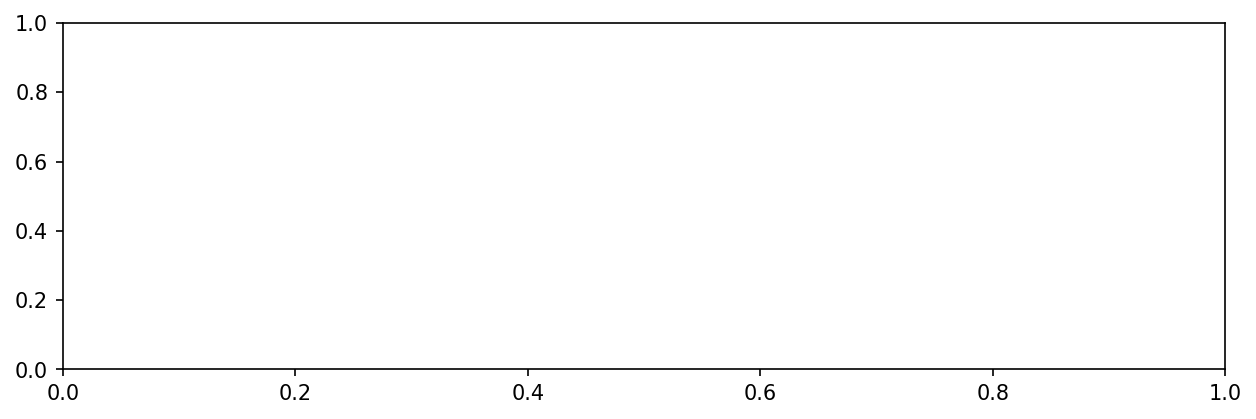

In [127]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(frame_times, calcium_trace, c='g')
ax.set_xlabel('time (sec)')
ax.set_ylabel('Fluorescence')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [ ]:
# lets zoom in on one portion to see some transients
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(frame_times[3000:4000], calcium_trace[3000:4000], c='g')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Fluorescence')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 1.11:</b> Pull out all the fluorescence traces from a single field. Hint, use * join on a filtered ScanUnit table.  Use fetch to return all the traces, use np.vstack to concatentate them all together into a matrix.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Oracle score  </h3>
    
The oracle score is a leave-one-out correlation for repeated segments of stimulus. It provides an estimate of visual response reliability for a given unit over the course of the scan. For more detail see the technical documentation found <a href="https://www.microns-explorer.org/cortical-mm3#f-data">here</a>.

Oracle scores are found in `nda.Oracle`. 

*Note that only masks classified as "soma" in `nda.MaskClassification` currently have oracle scores computed. This may change in a future version.*
</div>


In [ ]:
oracles = (nda.Oracle & scan_key).fetch('pearson')

In [ ]:
fig, ax = plt.subplots()
ax.hist(oracles, bins=50, color='k');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [ ]:
high_oracle_percentile = np.percentile(oracles, 99)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
 
Oracle scores greater than a threshold value can be specified by restricting the table with a string: `'pearson>x'` where `x` is the oracle value threshold.
</div>


In [ ]:
high_oracle_percentile

In [ ]:
high_oracle_table = nda.Oracle & scan_key & f'pearson>{high_oracle_percentile}'
high_oracle_table

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Select the nth entry in the table by passing an `offset` and `limit` to the `fetch` method.
</div>


In [ ]:
unit_key = high_oracle_table.fetch('KEY', offset=60, limit=1)[0]
unit_key

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Plot Oracle Raster </h3>
    
The function `fetch_oracle_raster` provided in the `func` module retrieves the responses for the functional unit for the repeated stimulus trials (oracle trials).
    
This function is useful to study as a lesson in how to access data from particular clips.
    
</div>



In [ ]:
oracle_traces, score = func.fetch_oracle_raster(unit_key)

In [ ]:
fig,axes = plt.subplots(1,6, figsize=(6,1),dpi=300)
for col,clip_trace in zip(axes,np.moveaxis(oracle_traces,1,0)):
    col.imshow(clip_trace,cmap='binary', interpolation='nearest')
    col.set_aspect('auto')
    col.set_xticks([])
    col.set_yticks([])
axes[0].set_ylabel(f'oracle score: {score:.2f}', fontsize=5)
fig.subplots_adjust(wspace=.05)
[ax.set_title(f'oracle clip {i+1}', fontsize=6) for i, ax in enumerate(axes)];
fig.suptitle(f'session: {unit_key["session"]}, scan_idx: {unit_key["scan_idx"]}, unit_id: {unit_key["unit_id"]}', fontsize=7, y=1.2)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Spike Traces </h3>
    
Spike traces are in `nda.Activity` and associated with single units (`unit_id's`).  This is a derived data product from the fluorescnece which tries to deconvolve the fluorescence into a series of impulse functions of different heights to reduce the effects of calcium dynamics and noise in the fluorescence traces.
</div>


In [ ]:
nda.Activity() & unit_key

In [ ]:
spike_trace = (nda.Activity() & unit_key).fetch1('trace')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(spike_trace, c='k')
ax.set_xlabel('Frames')
ax.set_ylabel('Spike trace')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> View fluorescence trace, and spike trace for the same unit </h3>
    
Use `nda.ScanUnit` to bridge between `unit_id` and `mask_id` to plot both the calcium trace spike trace and for a single unit.
</div>


In [ ]:
nda.Fluorescence & (nda.ScanUnit & unit_key)

In [ ]:
calcium_trace = (nda.Fluorescence & (nda.ScanUnit & unit_key)).fetch1('trace')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(calcium_trace/ np.max(calcium_trace), c='g', alpha=0.5, label='calcium')
ax.plot(spike_trace/ np.max(spike_trace), c='k', label='spike', alpha=0.5)
ax.set_xlabel('Frames')
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [ ]:
# lets zoom in to see the relationship more clearly
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(calcium_trace[4000:4500]/ np.max(calcium_trace), c='g', alpha=0.5, label='Fluorscence')
ax.plot(spike_trace[4000:4500]/ np.max(spike_trace), c='k', label='Activity', alpha=0.5)
ax.set_xlabel('Frames')
ax.set_ylabel('Aribtrary Units')
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Function - Structure Coregistration </h3>
    
Now that you understand how to access the activity of individual units, how do you relate those units to cells in the structural dataset?  We do this by registering the imaging data in vivo to the ex vivo EM structural data through a series of transforms and finally some manual validation of the correspondance.  You can skip over the details of how we do that, and instead focus just on the table of manually verified co-registration results, which are available as a table in the caveclient.  There are almost 10K cells available that, and contain this co-registration. 

Lets look at this table with the caveclient.
</div>


In [ ]:
import caveclient
client = caveclient.CAVEclient('minnie65_public_v343')
cr_df = client.materialize.query_table('functional_coreg')
cr_df.head()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Each row is a functional ROI which has been linked to the EM. 

You can see the important columns here are

* **pt_root_id** : the seg_id/root_id of the EM segmentation
* **session** : the session of this ScanUnit
* **scan_idx** : the scan_idex of this ScanUnit
* **unit_id** : the unit_id of this unit_id

We can use rows from this dataframe to restrict the ScanUnit table
</div>


In [ ]:
coreg_scan_units_top50 = pd.DataFrame(nda.ScanUnit() & cr_df.head(50))
coreg_scan_units_top50.head()

In [ ]:
print(len(coreg_scan_units_top50))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
And lets pull out the flourescence from these units
</div>


In [ ]:
first5_fluorescence=(nda.Fluorescence & coreg_scan_units_top50).fetch('trace')

In [ ]:
# this comes back as array of arrays
# lets make it a matrix
first5_flourescence = np.vstack(first5_fluorescence)

In [ ]:
first5_flourescence.shape

In [ ]:
# lets plot the raw values for the first 200 frames
f, ax = plt.subplots()
lines=ax.plot(first5_flourescence.T[0:2000,:])
ax.set_xlabel('frames')
ax.set_ylabel('fluorescence (AU)')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Exercise 1:</b>  Plot the fluorescence and activity trace of the highest oracle scoring proofread layer 2/3 pyramidal cell
</div>


In [ ]:
# merge proofreading status and cell type predictions to find an extended axons of the right type


In [ ]:
# merge in the co-registration to find which are coregistered.


In [ ]:
# use datajoint to find the oracle scores for these units 


In [ ]:
# find a unit with a high oracle score 


In [ ]:
# pull out its fluorescence


In [ ]:
# pull out its activity


In [ ]:
# plot them together
# lets zoom in to see the relationship more clearly


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Exercise 2:</b> Find the ScanUnits within a field with the largest average response to the monet stimulus in a scan.  Find out which of these are coregistered to the structural data.  Which direction has the largest response? How consistent is that response across other monet stimuli with the same directions?
</div>


In [ ]:
# filter out the Trial table for the unit you selected in Exercise 1 and the Monet type




In [ ]:
# pick a field key


In [ ]:
# pick out the fluorescence for these units as a N x 40000 matrix


In [ ]:
# pick out the activity for these units as a N x 40000 matrix


In [ ]:
# get the frame times for the scan


In [ ]:
# get the monet trials for this frame from the Trial table as a dataframe


In [ ]:
# loop over the monet trials and sum the fluorescence during the monet trials across time
# collect the mean of these responses for neurons in the field


In [ ]:
# plot the responses across the monet Trials


In [ ]:
# order the neurons by their mean response across trials. 
# use this to pick out the index of the kth most responsive neuron


In [ ]:
# plot this neuron across the monet trials


In [ ]:
# plot out the raw fluorescence data from one of the highly responsive trials


In [ ]:
# cutout each of the directions, reorder them 
#and plot the fluorescence by direction

# first construct the directions dataframe as we did above for this trial
# hint, filter on nda.Monet2 with the high trial row converted to a dictionary


# sort the times with respect to directions


In [ ]:
# now loop through the directions and cutout the fluorescence and activity
# plot both, normalizing by the maximum seen in this trial



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Mean Intensity </h3>
    
The mean intensity of the calcium signal for the entire field is computed per frame for the duration of the scan. This is found in `nda.MeanIntensity`. Periods of low intensity may indicate a low quality stretch of scan, for example where water might have temporarily run out between the microscope objective and imaging site.
</div>


In [ ]:
intensities = (nda.MeanIntensity & field_key).fetch1('intensities')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(intensities, c='b', alpha=0.5)
ax.set_xlabel('Frames')
ax.set_ylabel('Field Mean Intensity')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Behavior </h2>
    
<h3> Pupil </h3>
    
The pupil radius for each scan is found in `nda.RawManualPupil` and `nda.ManualPupil`. 

`pupil_min_r` is the smaller of the two radii from the ellipse fit to the pupil and `pupil_maj_r` is the larger radius. 

The tracked position of the pupil is found in `pupil_x` and `pupil_y`. 

`nda.RawManualPupil` contains the pupil traces and `pupil_times` at the original acquisition rate.

`nda.ManualPupil` contains the pupil traces synced to the `field 1` scan times (found in the `field1_times` attribute in `nda.DepthTimes`)
</div>




In [ ]:
nda.RawManualPupil() & scan_key

In [ ]:
nda.ManualPupil & scan_key

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Treadmill </h3>
    
The treadmill velocity for each scan is found in `nda.RawTreadmill` and `nda.Treadmill`.

`nda.RawTreadmill` contains the treadmill velocity trace and timestamps at the original acquisition rate.

`nda.Treadmill` contains the treadmill velocity trace synced to the `field 1` scan times (found in the `field1_times` attribute in `nda.DepthTimes`)
</div>


In [ ]:
nda.RawTreadmill & scan_key

In [ ]:
nda.Treadmill & scan_key

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h2> Visualize area labels in 2P stack space </h2>
    
<h3> Area Membership </h3>
    
Computed area membership labels are found in `nda.AreaMembership`.
    
View area labels for units in 2D space (x, y) in stack reference frame.

</div>



In [100]:
nda.AreaMembership()

session Session ID,scan_idx Scan ID,unit_id unique per scan,brain_area Visual area membership of unit
4,7,1,LM
4,7,2,LM
4,7,3,LM
4,7,4,LM
4,7,5,LM
4,7,6,LM
4,7,7,LM
4,7,8,LM
4,7,9,LM
4,7,10,LM


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Let's pull out the area membership of every stack unit, and use it to color a scatter plot
</div>

In [101]:
area, x, y = (nda.AreaMembership * nda.StackUnit).fetch('brain_area', 'stack_x', 'stack_y')

In [102]:
color_dict = {'LM':'blue', 'AL': 'green', 'RL': 'purple', 'V1': 'red'}

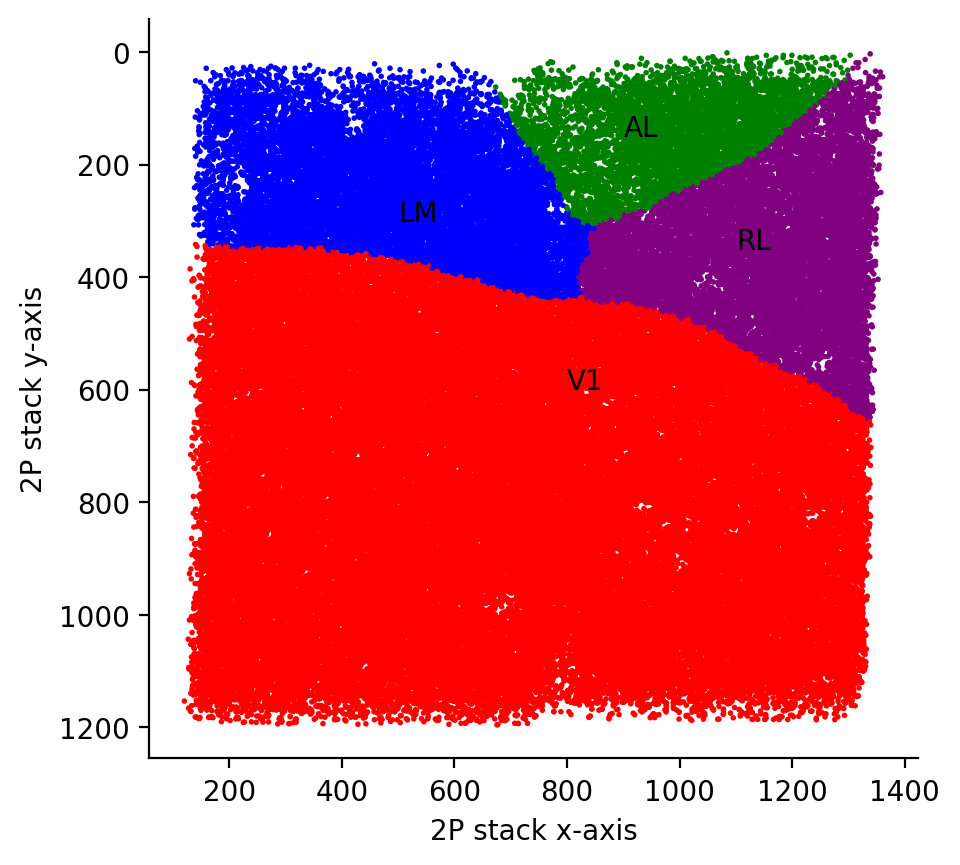

In [103]:
fig, ax = plt.subplots(dpi=200)
ax.scatter(x, y, color=[color_dict[a] for a in area], s=1)
ax.set_aspect('equal')
ax.invert_yaxis()
ax.set_xlabel('2P stack x-axis')
ax.set_ylabel('2P stack y-axis')
ax.annotate('LM', (500, 300))
ax.annotate('AL', (900, 150))
ax.annotate('RL', (1100, 350))
ax.annotate('V1', (800, 600))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)